In [1]:
import sys
sys.path.append('..')
from JensenTools import *
import PyCrystalField as cef
import numpy as np
import matplotlib.pyplot as plt

 *******************************************************
 *                PyCrystalField 2.3.1                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



In [2]:
# kwargs
#####################################################################################################################################################################
comp = 'Sr2PrO4'
ion = 'Ce3+'
who = 'Arun'
LS_on = True
Kmeans = True
LSValue = 100
numlevels = 4
# The L,S values are as follows for the Pr4+ ion
L = 3
S = 0.5
molweight = 380.15
#####################################################################################################################################################################

In [3]:
# Make LS_CFLevels object with best fit parameters
#####################################################################################################################################################################
B20  =  0.4858075931009187
B40  =  -0.6568663783690575
B44  =  -3.1415463304732714
B60  =  -0.02328250024945387
B64  =  0.504906552605772
LS  =  100.00007580463522

saveDir = getSaveDir('m',comp = comp) #General Directory for the project
MHDir = getSaveDir('m',comp = comp, dataType = 'MH') #MvsH data

stev = { 'B20' :B20, 'B40': B40, 'B44' : B44, 'B60': B60, 'B64' : B64 }

#Create the CFLevels object and diagonalize it
if LS_on:
	Pr = cef.LS_CFLevels.Bdict(Bdict = stev, L = L, S = S, SpinOrbitCoupling=LS)
	Pr.diagonalize()
else:
	Pr = cef.CFLevels.Bdict(Bdict = stev, ion = 'Ce3+')
	Pr.diagonalize()
#####################################################################################################################################################################	

In [4]:
# Loading data for M vs H
#####################################################################################################################################################################
runs = []
for i in os.listdir(MHDir):
    if i.endswith('.DAT'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)
MHdata = {}
for i in runs:
    M, H, Err, mass, T = getData(i,MHDir,who = who, dataType = 'MH')
    MHdata[T] = [M,H,Err,mass,i]
# Choosing 20K run
T = '20K'
Temp = getTemp(MHdata[T][-1], who = who)
M, H, Err, mass, filename = MHdata[T]
#####################################################################################################################################################################

In [5]:
# Use PCF to calculate Magnetization (uB)
# Also do unit conversions
#####################################################################################################################################################################
#These are from measured data normalized per spin
MEmu = normalize(M,mass,molweight,'spin')
MBohr = emuToBohr2(MEmu)
HTes = oeToTesla(H)

#Generate a magnetization curve for comparing results to experiment
magCalcBohr = []
for i in HTes:
	if LS_on:
		magCalcBohr.append(Pr.magnetization( Temp = Temp, Field = [0, 0, i])[2])		
	else:
		magCalcBohr.append(Pr.magnetization( Temp = Temp, Field = [0, 0, i], ion = ion)[2])

# Convert calculated magnetization to emu per spin
magCalcBohr = np.array(magCalcBohr)
magCalcEmu = bohrToEmu2(magCalcBohr)
#####################################################################################################################################################################

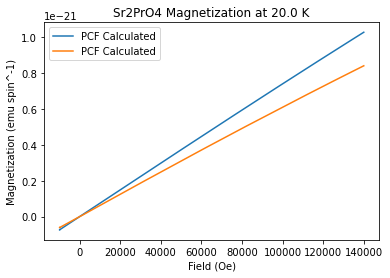

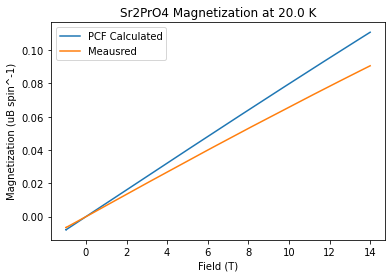

In [6]:
# Plot magnetization for:
# Calculated and measured: in (uB) and (emu)
#####################################################################################################################################################################
plt.figure()
plt.plot(H,-1*magCalcEmu, label = 'PCF Calculated')
plt.plot(H,MEmu, label = 'PCF Calculated')
plt.xlabel('Field (Oe)')
plt.ylabel('Magnetization (emu spin^-1)')
plt.title('{} Magnetization at {} K'.format(comp,Temp))
plt.legend()


plt.figure()
plt.plot(HTes,-1*magCalcBohr, label = 'PCF Calculated')
plt.plot(HTes,MBohr, label = 'Meausred')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (uB spin^-1)')
plt.title('{} Magnetization at {} K'.format(comp,Temp))
plt.legend()


# plt.figure()
# plt.plot(H,MEmu, label = 'Meausred')
# plt.xlabel('Field (Oe)')
# plt.ylabel('Magnetization (emu Oe^-1 mol^-1)')
# plt.title('{} Magnetization at {} K'.format(comp,Temp))
# plt.legend()

# plt.figure()
# plt.plot(HTes,MBohr, label = 'Meausred')
# plt.xlabel('Field (T)')
# plt.ylabel('Magnetization (uB T^-1 mol^-1)')
# plt.title('{} Magnetization at {} K'.format(comp,Temp))
# plt.legend()
plt.show()
#####################################################################################################################################################################